In [1]:
import numpy as np
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torch.multiprocessing as mp
from datetime import datetime

import pdb

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Utils
import data_generator
from variational_layer import VariationalLayer

In [2]:
is_cuda = False
dev = torch.device('cpu')  
if torch.cuda.is_available():
    is_cuda = True
    dev = torch.device('cuda')  

In [3]:
N = 5000
N_train = 3000
N_valid = N - N_train

In [4]:
X, y = data_generator.data_4to4(N)
X, y_perfect = data_generator.data_4to4(N, noise_level=0)

### Plot if output data is 1D
pca = PCA(n_components=1)
pca.fit(X)
X_plot = pca.transform(X)

fig,ax = plt.subplots(figsize=(6,3), dpi=120)
plt.scatter(X_plot, y, c='blue', alpha=0.2, s=5)
plt.scatter(X_plot, y_perfect, c='r', alpha=0.7, s=0.3)

In [5]:
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

In [6]:
class ArtificialDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        return

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X_i = self.X[idx]
        y_i = self.y[idx]

        return X_i, y_i

In [7]:
dataset = ArtificialDataset(X, y)

data_train, data_valid = torch.utils.data.random_split(
    dataset, [N_train, N_valid])

BATCH_SIZE_LOADER = 64

training_loader = torch.utils.data.DataLoader(
    data_train, batch_size=BATCH_SIZE_LOADER,
    shuffle=True, num_workers=mp.cpu_count())

validation_loader = torch.utils.data.DataLoader(
    data_valid, batch_size=BATCH_SIZE_LOADER,
    shuffle=True, num_workers=mp.cpu_count())

In [8]:
class VariationalNet(nn.Module):
    # Initialize the layers
    def __init__(self, n_samples, input_size, output_size, K):
        super().__init__()
        self.n_samples = n_samples
        self.act1 = nn.ReLU()
        self.act2 = nn.Tanh()
        self.act3 = nn.Sigmoid()
        self.linear1 = VariationalLayer(input_size, 32, 0, 3, n_samples)
        #self.bn = nn.BatchNorm1d(16)
        self.linear2 = VariationalLayer(32, 16, 0, 3, n_samples)
        self.linear3 = VariationalLayer(16, output_size, 0, 3, n_samples)
        self.K = K
    
    # Perform the computation
    def forward(self, x):
        #pdb.set_trace()
        x = torch.unsqueeze(x, 0)
        x = x.expand((self.n_samples, x.shape[1], x.shape[2]))
        x = self.linear1(x)
        #x = self.bn(x)
        x = self.act1(x)
        x = self.linear2(x)
        x = self.act1(x)
        x = self.linear3(x)
        return x
    
    def kl_divergence_NN(self):
        kl = (
            self.linear1.kl_divergence_layer() 
            + self.linear2.kl_divergence_layer()
            + self.linear3.kl_divergence_layer()
        )
        return kl

In [9]:
n_samples = 10
input_size = X.shape[1]
output_size = y.shape[1]

K = 1/5

In [10]:
h = VariationalNet(n_samples, input_size, output_size, K).to(dev)
#h1 = ANN(input_size, output_size).to(dev)
#h2 = BayesianNetwork(1).to(dev)
opt_h = torch.optim.Adam(h.parameters(), lr=0.005)

mse_loss_mean = nn.MSELoss(reduction='mean')
mse_loss_sum = nn.MSELoss(reduction='sum')

In [11]:
BATCH_SIZE = 64

In [12]:
def train_one_epoch(epoch_index):
    
    mse_running_loss = 0.
    kl_running_loss = 0.
    
    n = len(training_loader.dataset)

    for i, data in enumerate(training_loader):
        
        x_batch, y_batch = data
        opt_h.zero_grad()

        y_preds = h(x_batch)
        y_preds_mean = y_preds.mean(axis=0).squeeze()

        mse_loss_ = mse_loss_sum(y_preds_mean, y_batch)
        kl_loss_ = h.K*h.kl_divergence_NN()
        
        elbo_loss = mse_loss_ + kl_loss_
        elbo_loss.backward()
        
        opt_h.step()
        
        mse_running_loss += mse_loss_.item()
        kl_running_loss += kl_loss_.item()
        
    mse = mse_running_loss/n
    kl = kl_running_loss/n

    return mse, kl

In [13]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
epoch_number = 0

EPOCHS = 150

for epoch in range(EPOCHS):
    print('------------------EPOCH {}------------------'.format(
        epoch_number + 1))

    h.train(True)
    avg_mse_loss, avg_kl_loss = train_one_epoch(
        epoch_number)
    avg_loss = avg_mse_loss + avg_kl_loss
    
    h.train(False)
    mse_running_loss_v = 0.0
    kl_running_loss_v = 0.0
    
    n = len(validation_loader.dataset)
    
    for i, vdata in enumerate(validation_loader):
        
        x_val_batch, y_val_batch = vdata

        y_val_preds = h(x_val_batch)
        y_val_preds_mean = y_val_preds.mean(axis=0).squeeze()
        
        mse_loss_ = mse_loss_sum(y_val_preds_mean, y_val_batch)
        kl_loss_ = h.K*h.kl_divergence_NN()
        elbo_loss = mse_loss_ + kl_loss_
        
        mse_running_loss_v += mse_loss_
        kl_running_loss_v += kl_loss_
        
    avg_vmseloss = (mse_running_loss_v / n).item()
    avg_vklloss = (kl_running_loss_v / n).item()
    
    avg_vloss = avg_vmseloss + avg_vklloss
    
    print('MSE LOSS \t train {} valid {}'.format(
        round(avg_mse_loss, 2), round(avg_vmseloss, 2)))
    print('KL LOSS \t train {} valid {}'.format(
        round(avg_kl_loss, 2), round(avg_vklloss, 2)))
    print('ELBO LOSS \t train {} valid {}'.format(
        round(avg_loss, 2), round(avg_vloss, 2)))

    epoch_number += 1

------------------EPOCH 1------------------
MSE LOSS 	 train 627.91 valid 478.88
KL LOSS 	 train 11.93 valid 11.98
ELBO LOSS 	 train 639.84 valid 490.86
------------------EPOCH 2------------------
MSE LOSS 	 train 480.32 valid 456.31
KL LOSS 	 train 11.56 valid 11.62
ELBO LOSS 	 train 491.88 valid 467.93
------------------EPOCH 3------------------
MSE LOSS 	 train 460.45 valid 454.1
KL LOSS 	 train 11.21 valid 11.28
ELBO LOSS 	 train 471.66 valid 465.38
------------------EPOCH 4------------------
MSE LOSS 	 train 454.03 valid 446.04
KL LOSS 	 train 10.89 valid 10.96
ELBO LOSS 	 train 464.92 valid 456.99
------------------EPOCH 5------------------
MSE LOSS 	 train 451.94 valid 444.59
KL LOSS 	 train 10.57 valid 10.64
ELBO LOSS 	 train 462.51 valid 455.23
------------------EPOCH 6------------------
MSE LOSS 	 train 450.6 valid 444.94
KL LOSS 	 train 10.27 valid 10.33
ELBO LOSS 	 train 460.87 valid 455.27
------------------EPOCH 7------------------
MSE LOSS 	 train 450.3 valid 444.61
KL L

MSE LOSS 	 train 446.37 valid 447.0
KL LOSS 	 train 5.81 valid 5.92
ELBO LOSS 	 train 452.18 valid 452.92
------------------EPOCH 56------------------
MSE LOSS 	 train 446.94 valid 445.92
KL LOSS 	 train 5.79 valid 5.9
ELBO LOSS 	 train 452.74 valid 451.82
------------------EPOCH 57------------------
MSE LOSS 	 train 447.75 valid 447.29
KL LOSS 	 train 5.78 valid 5.88
ELBO LOSS 	 train 453.53 valid 453.17
------------------EPOCH 58------------------
MSE LOSS 	 train 445.85 valid 445.45
KL LOSS 	 train 5.75 valid 5.87
ELBO LOSS 	 train 451.6 valid 451.32
------------------EPOCH 59------------------
MSE LOSS 	 train 446.64 valid 447.45
KL LOSS 	 train 5.73 valid 5.85
ELBO LOSS 	 train 452.37 valid 453.3
------------------EPOCH 60------------------
MSE LOSS 	 train 447.02 valid 446.14
KL LOSS 	 train 5.72 valid 5.84
ELBO LOSS 	 train 452.74 valid 451.98
------------------EPOCH 61------------------
MSE LOSS 	 train 446.42 valid 445.49
KL LOSS 	 train 5.71 valid 5.81
ELBO LOSS 	 train 452.1

MSE LOSS 	 train 443.44 valid 448.93
KL LOSS 	 train 5.21 valid 5.32
ELBO LOSS 	 train 448.65 valid 454.24
------------------EPOCH 110------------------
MSE LOSS 	 train 444.56 valid 448.33
KL LOSS 	 train 5.21 valid 5.31
ELBO LOSS 	 train 449.76 valid 453.64
------------------EPOCH 111------------------
MSE LOSS 	 train 444.7 valid 448.74
KL LOSS 	 train 5.2 valid 5.3
ELBO LOSS 	 train 449.9 valid 454.05
------------------EPOCH 112------------------
MSE LOSS 	 train 444.05 valid 448.82
KL LOSS 	 train 5.19 valid 5.3
ELBO LOSS 	 train 449.25 valid 454.12
------------------EPOCH 113------------------
MSE LOSS 	 train 444.23 valid 448.87
KL LOSS 	 train 5.19 valid 5.29
ELBO LOSS 	 train 449.42 valid 454.16
------------------EPOCH 114------------------
MSE LOSS 	 train 444.98 valid 449.08
KL LOSS 	 train 5.18 valid 5.29
ELBO LOSS 	 train 450.16 valid 454.36
------------------EPOCH 115------------------
MSE LOSS 	 train 444.17 valid 448.64
KL LOSS 	 train 5.17 valid 5.29
ELBO LOSS 	 train 

In [16]:
h(validation_loader.dataset.dataset.X).shape

torch.Size([10, 5000, 4])

In [66]:
def plot_test_curve(X_test, y_test, h):
    xt = torch.hstack(
    (X_test[:,0], 
     torch.tensor(np.arange(-1.4, -1, 1/500), dtype = torch.float32), 
     torch.tensor(np.arange(1, 1.4, 1/500), dtype = torch.float32)))
    
    plt.scatter(X_test[:,0].detach(), y_test.detach())
    for i in range(0, 100):
        plt.scatter(xt.detach(), 
                    h(xt.unsqueeze(1)).detach().squeeze()[0], 
                    color='r', alpha=0.01)
        plt.ylim([-10, 10])

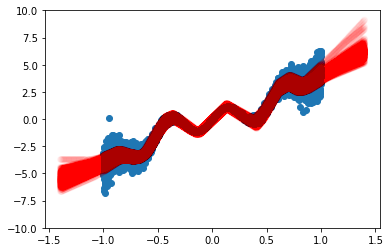

In [67]:
plot_test_curve(validation_loader.dataset.dataset.X,
               validation_loader.dataset.dataset.y,
               h)

In [19]:
Y_pred = h(validation_loader.dataset.dataset.X)

In [32]:
Y_pred.shape

torch.Size([10, 5000, 4])

In [28]:
BATCH_SIZE_OP = 8

sample = 0

In [44]:
batch = torch.randint(0, Y_pred.shape[1], (BATCH_SIZE_OP,))

In [49]:
qy_00 = Y_pred[sample, batch, 0]
qy_01 = Y_pred[sample, batch, 1]
qy_10 = Y_pred[sample, batch, 1]
qy_11 = Y_pred[sample, batch, 2]

cy_0 = Y_pred[sample, batch, 0]
cy_1 = Y_pred[sample, batch, 2]

Qy = torch.zeros((BATCH_SIZE_OP, 2, 2))
cy = torch.zeros((BATCH_SIZE_OP, 2))

Qy[:,0,0] = qy_00
Qy[:,0,1] = qy_01
Qy[:,1,0] = qy_10
Qy[:,1,1] = qy_11

cy[:,0] = cy_0
cy[:,1] = cy_1

In [54]:
cy

tensor([[ 9.5101, 11.8222],
        [ 9.3594, 10.2748],
        [ 8.5177, 14.6552],
        [ 8.1419, 13.0726],
        [ 7.9186, 10.3805],
        [ 7.7878,  9.2600],
        [12.7521,  9.3533],
        [11.0066, 10.7209]], grad_fn=<CopySlices>)

In [29]:
Qy[,,]

tensor([[[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]]])

In [24]:
torch.zeros((BATCH_SIZE_OP, 2, 2)).shape

torch.Size([8, 2, 2])

In [ ]:
# Quadratic Programming (Q, c, A, b):



In [ ]:
y